In [10]:
workspace = '/data/ChaochaoData/DSA-DL/HyperMorph/MinMax/'
util_dir = '/data/ChaochaoData/DSA-DL/Utilities/'
train_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTrain'
test_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTest'
cm_train_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/train_dataset'
cm_test_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/test_dataset'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
# plt.rcParams['animation.ffmpeg_path'] = '/usr/local/lib/python3.8/dist-packages'
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import neurite as ne
import voxelmorph as vxm
import tensorflow as tf
import os, sys, shutil
import nibabel as nib
import cv2
# from scipy import ndimage
# from IPython import display  # Would conflict with Python's display
import IPython
import logging
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.experimental.output_all_intermediates(True)
tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

2023-10-26 20:06:43.671914: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# import ipywidgets
# import bokeh
# import bokeh.io
# import bokeh.plotting
# bokeh.io.output_notebook()

In [4]:
# sys.path.insert(0, workspace)
sys.path.insert(0, util_dir)
from utils import *

Loading BokehJS ...

# Data

In [5]:
folders_train_old = [os.path.join(train_dir, f) for f in sorted(os.listdir(train_dir))
                     if not os.path.isfile(os.path.join(train_dir, f))]
folders_test_old = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))
                    if not os.path.isfile(os.path.join(test_dir, f))]
print(len(folders_train_old), len(folders_test_old))

folders_train_cm = [os.path.join(cm_train_dir, f) for f in sorted(os.listdir(cm_train_dir))
                    if not os.path.isfile(os.path.join(cm_train_dir, f))]
folders_test_cm = [os.path.join(cm_test_dir, f) for f in sorted(os.listdir(cm_test_dir))
                   if not os.path.isfile(os.path.join(cm_test_dir, f))]
print(len(folders_train_cm), len(folders_test_cm))

folders_train = folders_train_old + folders_train_cm
folders_test = folders_test_old + folders_test_cm
print(len(folders_train), len(folders_test))

4946 100
100 94
5046 194


# Model

In [6]:
# model_path = workspace + 'dsa_hyper_cycle.h5'
# model = vxm.networks.HyperVxmDense.load(model_path)  # doesn't work???

In [7]:
image_shape = (512, 512)

hp_input = tf.keras.Input(shape=[1])
x = tf.keras.layers.Dense(32, activation='relu')(hp_input)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
hypernetwork = tf.keras.Model(hp_input, x, name='hypernetwork')
# hypernetwork.summary()

model = vxm.networks.VxmDense(image_shape, int_steps=0, bidir=True, hyp_model=hypernetwork)
# model.summary()

In [11]:
model_path = workspace + 'dsa_hyper_cycle.h5'

if os.path.exists(model_path):
  model.load_weights(model_path)
  print('Model has been found and loaded')

2023-10-26 20:09:18.537540: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 20:09:19.282149: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-10-26 20:09:19.282360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41730 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d5:00.0, compute capability: 8.6
2023-10-26 20:09:19.392192: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Model has been found and loaded


# Visual Examination

In [12]:
%matplotlib inline
folders_sel = folders_test
i_seq = np.random.randint(len(folders_sel))

In [13]:
xrays = load_xray_seq(folders=folders_sel, i_seq=i_seq)
print(f'check xray seq range: [{xrays.min()}, {xrays.max()}]')

check xray seq range: [0.0, 1.0]


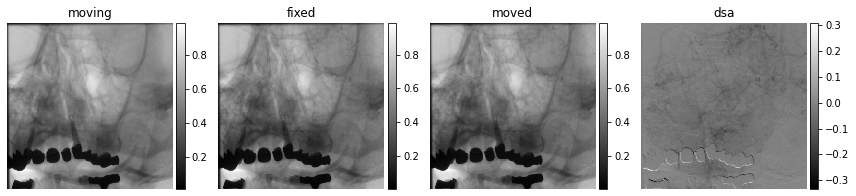

In [14]:
## Original DSA

inputs, outputs = hpm_seq_generator(folders=folders_sel, i_seq=i_seq, nhps=1, bidir=True)

image_moving = inputs[0][0:1]
image_fixed = inputs[1][0:1]
image_moved = outputs[0][0:1]
dsa = image_fixed - image_moving

images = [image_moving.squeeze(), image_fixed.squeeze(), image_moved.squeeze(), dsa.squeeze()]
titles = ['moving', 'fixed', 'moved', 'dsa']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=len(images)*3);

λ: 0.50


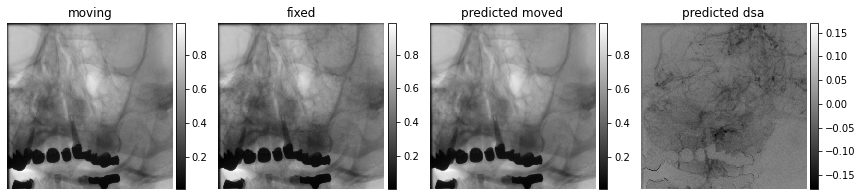

In [17]:
## Predicted DSA

hyperparam = np.array([[0.5]])
print(f'λ: {hyperparam[0,0]:.2f}')

pred = model.predict((image_moving, image_fixed, hyperparam), verbose=0)
image_pred = pred[0]
warp_pred = pred[-1]

dsa_pred = image_fixed - image_pred

images = [image_moving.squeeze(), image_fixed.squeeze(), image_pred.squeeze(), dsa_pred.squeeze()]
titles = ['moving', 'fixed', 'predicted moved', 'predicted dsa']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=len(images)*3);

# Testing

In [19]:
%matplotlib inline
folders_sel = folders_test
i_seq = np.random.randint(len(folders_sel))
print(i_seq)

76


In [20]:
inputs, outputs = hpm_seq_generator(folders_sel, i_seq, bidir=True)
print(inputs[0].shape, inputs[1].shape, inputs[2].shape)
print(outputs[0].shape, outputs[1].shape, outputs[2].shape)

(22, 512, 512, 1) (22, 512, 512, 1) (22, 1)
(22, 512, 512, 1) (22, 512, 512, 1) (22, 512, 512, 2)


Is image_fixed same as image_moved?  True


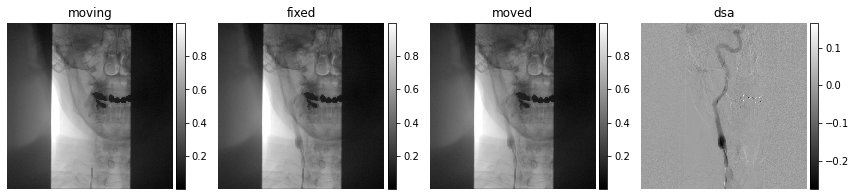

In [21]:
i_img = np.random.randint(inputs[0].shape[0])
image_moving = inputs[0][i_img]
image_fixed = inputs[1][i_img]
image_moved = outputs[0][i_img]
dsa = image_fixed - image_moving
print( 'Is image_fixed same as image_moved? ', np.array_equal(image_fixed, image_moved) )

images = [image_moving.squeeze(), image_fixed.squeeze(), image_moved.squeeze(), dsa.squeeze()]
titles = ['moving', 'fixed', 'moved', 'dsa']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=len(images)*3);

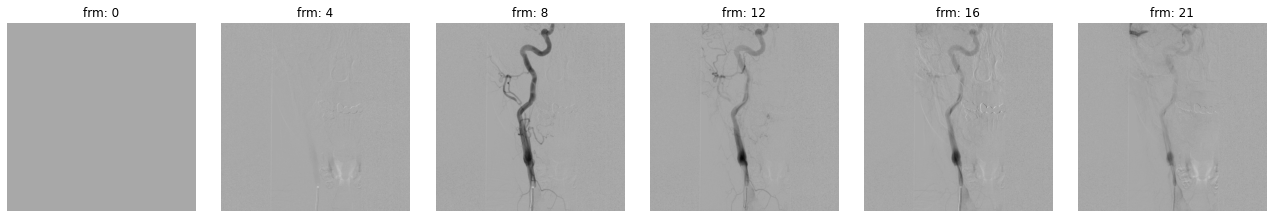

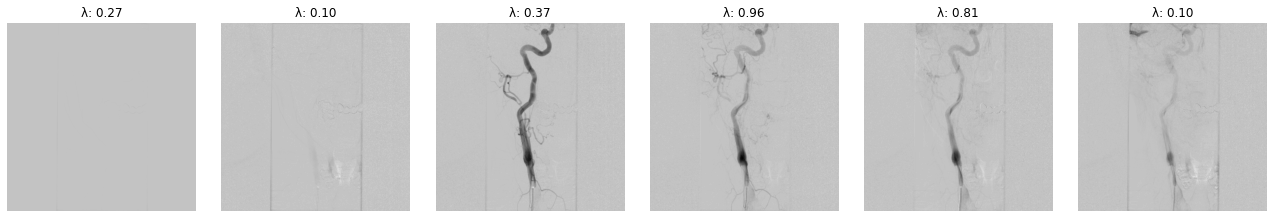

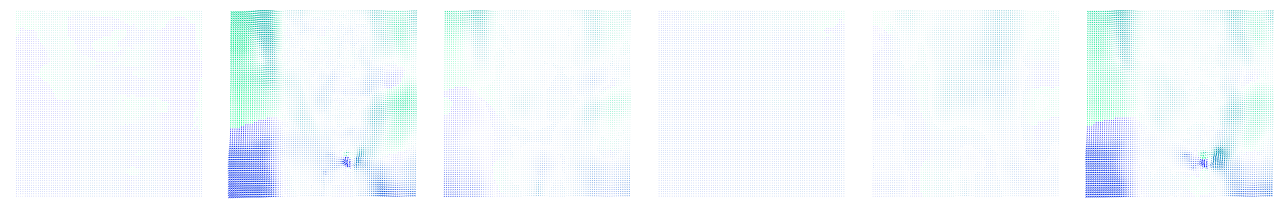

In [22]:
plot_dsa_predictions(model=model, folders=folders_sel, i_seq=i_seq, nhps=1)

In [23]:
xrays = load_xray_seq(folders=folders_sel, i_seq=i_seq)
run_interactive_search_1p(model, xrays, hp0=0.5)

Output()

# Nifti

In [24]:
affine = [[0, -1, 0, 0],
          [-1, 0, 0, 0],
          [0, 0, 1, 0],
          [0, 0, 0, 1]]

def output_nifti(images, path):
    images = np.squeeze(images)
    images = np.moveaxis(images, 0, -1)
    images = (images - images.min()) / (images.max() - images.min())
    images = images * 4095.
    
    image = nib.Nifti1Image(images, affine)
    image.to_filename(path)     

In [25]:
out_dir = os.path.join(workspace, 'test_outputs')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print("directory has been created")

In [26]:
## Output input
src = os.path.join(folders_sel[i_seq], 'input.nii')
dst = os.path.join(workspace, 'test_outputs/input.nii')
shutil.copyfile(src, dst)
os.path.exists(src)

True

In [27]:
## Output background and predicted dsa
hp_lambda = 0.5

idx_f0 = 0
nx = xrays.shape[0]

xa_m = np.repeat(xrays[idx_f0][None], nx, axis=0)
xa_f = xrays
hp = np.repeat(np.array([[hp_lambda]]), nx, axis=0)

inputs = [xa_m, xa_f, hp]
preds = model.predict(inputs, verbose=0) 
moved = preds[0]

dsa_bg = xa_f - xa_m
dsa_pred = xa_f - moved 

output_nifti(dsa_bg, os.path.join(workspace, 'test_outputs/dsa_bg.nii'))
output_nifti(dsa_pred, os.path.join(workspace, 'test_outputs/dsa_pred.nii'))

# Flow Animation

<IPython.core.display.Javascript object>


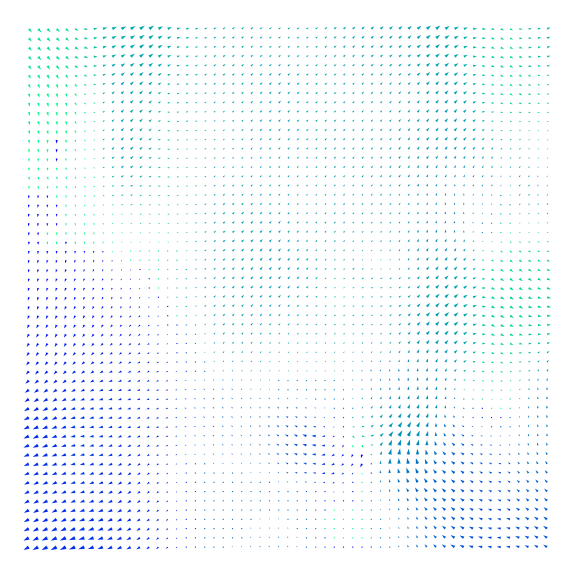

In [28]:
%matplotlib notebook

warps = preds[-1]

## Function to update the figure for each frame
def update(frame):
    warp = np.copy(warps[frame,::9,::9,:]) # Since img_indexing, indexing may modify slices_in in memory
    warp[:, :, 1] = -warp[:, :, 1]
    warp = np.flipud(warp) 

    u = warp[...,0]
    v = warp[...,1]

    colors = np.arctan2(u, v)
    colors[np.isnan(colors)] = 0
    norm = Normalize()
    norm.autoscale(colors)
    colormap = cm.winter
    quiver_width = None
    
    plt.cla()  # clear previous plot

    ax.quiver(u, v,
              color=colormap(norm(colors).flatten()),
              angles='xy',
              units='xy',
              width=quiver_width,
              scale=1)

    ax.axis('off')
    ax.axis('equal')

## Create a figure and axes
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(8, 8)
fig.patch.set_alpha(1)  # set background opaque

## Number of frames in the animation
num_frames = len(warps)

# Create an animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, repeat=False)

## Save the animation as a gif file
# gifwriter = animation.PillowWriter(fps=3)
# ani.save(os.path.join(out_dir, 'flow.gif'), writer=gifwriter)

## Save the animation as a video file
FFwriter = animation.FFMpegWriter(fps=3)
ani.save(os.path.join(out_dir, 'flow.mp4'), writer=FFwriter)

# plt.tight_layout()
plt.show()